# Training MLP to solve Sparse Parity

This setup involves 30 bits as input and 30 neurons in the hidden layer of the MLP.

No Differential Privacy is applied.

Epoch [50/500], Loss: 0.0699, Train Acc: 1.0000, Test Acc: 0.9670
Epoch [100/500], Loss: 0.0165, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [150/500], Loss: 0.0075, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [200/500], Loss: 0.0055, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [250/500], Loss: 0.0037, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [300/500], Loss: 0.0028, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [350/500], Loss: 0.0020, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [400/500], Loss: 0.0017, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [450/500], Loss: 0.0017, Train Acc: 1.0000, Test Acc: 1.0000
Epoch [500/500], Loss: 0.0017, Train Acc: 1.0000, Test Acc: 1.0000
Final Test Accuracy: 100.00%


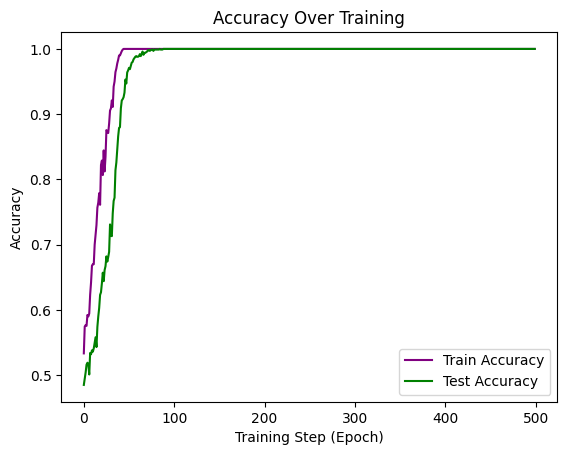

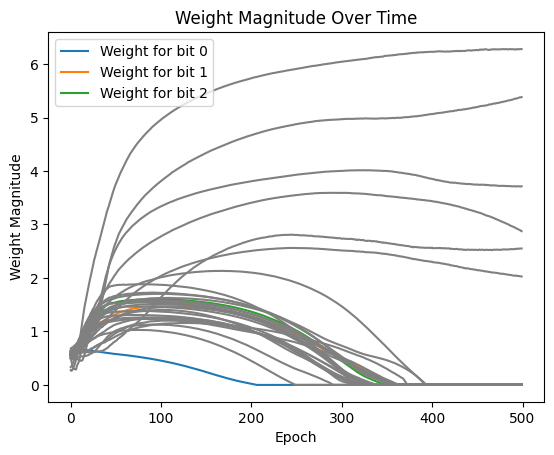

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)

train_size = 900
test_size = 1000
l1_lambda = 2e-05   # Weight decay
epochs = 500
batch_size = 32

# Data generation (parity check on first 3 bits, 30-bit input)
unique_binary_strings = set()
while len(unique_binary_strings) < train_size + test_size:
    binary_string = tuple(np.random.randint(2, size=30))
    unique_binary_strings.add(binary_string)

inputs = np.array(list(unique_binary_strings), dtype=np.float32)
outputs = np.sum(inputs[:, :3], axis=-1) % 2  # Parity check on first 3 bits

# Add bias column (column of ones)
ones_column = np.ones((inputs.shape[0], 1), dtype=np.float32)
inputs = np.concatenate((inputs, ones_column), axis=1)


indices = np.random.permutation(len(inputs))
X_train, y_train = inputs[indices[:train_size]], outputs[indices[:train_size]]
X_eval, y_eval = inputs[indices[train_size:]], outputs[indices[train_size:]]

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).view(-1, 1))
eval_dataset = TensorDataset(torch.tensor(X_eval), torch.tensor(y_eval).view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(31, 32)  # Input dim (30 features + 1 bias)
        self.fc2 = nn.Linear(32, 1)
        self.l1_lambda = l1_lambda

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

    def l1_regularization(self):
        return self.l1_lambda * (torch.abs(self.fc1.weight).sum() + torch.abs(self.fc2.weight).sum())


model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=l1_lambda)


train_accuracies = []
test_accuracies = []
weights_over_time = []


for epoch in range(epochs):
    model.train()
    
    for inputs_batch, targets_batch in train_loader:
        optimizer.zero_grad()
        
        outputs_train = model(inputs_batch)
        loss = criterion(outputs_train, targets_batch) + model.l1_regularization()
        
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        outputs_train_full = model(torch.tensor(X_train))
        train_accuracy = ((outputs_train_full > 0.5).float() == torch.tensor(y_train).view(-1, 1)).float().mean().item()
        train_accuracies.append(train_accuracy)

    model.eval()
    outputs_eval = model(torch.tensor(X_eval))
    test_accuracy = ((outputs_eval > 0.5).float() == torch.tensor(y_eval).view(-1, 1)).float().mean().item()
    test_accuracies.append(test_accuracy)

    weights_over_time.append(model.fc1.weight.data.clone().cpu().numpy())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


plt.plot(train_accuracies, label='Train Accuracy', color='purple')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy Over Training')
plt.xlabel('Training Step (Epoch)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


weights_over_time = np.array(weights_over_time)
for i in range(3):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), label=f'Weight for bit {i}')

for i in range(3, 30):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), color='gray')
    
#plt.plot(np.linalg.norm(weights_over_time[:, 3:, :], axis=-1).mean(axis=1), label='Average of distracting weights')
plt.title('Weight Magnitude Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Magnitude')
plt.legend()
plt.show()